# OPeNDAP Access

#### Notebook Objectives:
- Search the common metadata repository (CMR) for the MUR dataset
- Obtain OPeNDAP links from CMR search
- Download data from OPeNDAP links and open via xarray to visualize data

In [1]:
#https://ghrc.nsstc.nasa.gov/opendap/globalir/data/2020/0525/globir.20146.0000
from netCDF4 import Dataset
import xarray as xr
import dask
import os
import requests

#Allows us to visualize the dask progress for parallel operations
from dask.diagnostics import ProgressBar
ProgressBar().register()


## Before you start

Before you beginning this tutorial, make sure you have an account in the Earthdata Login, which is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register for an Earthdata Login account. It is free to create and only takes a moment to set up.

You will also need a netrc file containing your NASA Earthdata Login credentials in order to execute this notebook. A netrc file can be created manually within text editor and saved to your home directory. For additional information see: [Authentication for NASA Earthdata](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/04_NASA_Earthdata_Authentication.html#authentication-via-netrc-file) 

In this notebook, we will be calling the authentication in the below cell, a work around if you do not yet have a netrc file.

In [15]:
import urllib
from urllib import request, parse
from http.cookiejar import CookieJar
import json
import getpass
import netrc

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file
    first and if no credentials are found, it prompts for them.
    Valid endpoints include:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

edl="urs.earthdata.nasa.gov"

setup_earthdata_login_auth(edl)

Please provide your Earthdata Login credentials to allow data access
Your credentials will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter


Username: nickles
 ···········


In [6]:
#CMR Link to use
#https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1625128926-GHRC_CLOUD&temporal=2019-01-01T10:00:00Z,2019-12-31T23:59:59Z
r = requests.get('https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1996881146-POCLOUD&temporal=2019-01-01T10:00:00Z,2019-02-01T00:00:00Z&pageSize=365')
response_body = r.json()

In [7]:
od_files = []
for itm in response_body['items']:
    for urls in itm['umm']['RelatedUrls']:
        if 'OPeNDAP' in urls['Description']:
            od_files.append(urls['URL'])

od_files
        

['https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/G

In [8]:
len(od_files)

32

In [9]:
for f in od_files:
    print (" opening " + f)
    data_url = f'{f}.dap.nc4'
    
    
    # The notation below is [start index, step, end index]
    # lat[ /lat= 0..17998] start index. = -90
    # lon[ /lon= 0..35999] start index. = -180
    # time[ /time= 0..0] 
    required_variables = {'analysed_sst[0:1:0][000:1:9000][000:1:9000]',
                          'analysis_error[0:1:0][000:1:9000][000:1:9000]',
                          'lat[000:1:9000]',
                          'lon[000:1:9000]',
                         'time[0:1:0]'}

    #upper latitude, left longitude, lower latitude, right longitude

    basename = os.path.basename(data_url)
    request_params = {'dap4.ce': ';'.join(required_variables)}
    #identity encoding to work around an issue with server side response compression (??)
    response = requests.get(data_url, params=request_params,  headers={'Accept-Encoding': 'identity'})

    if response.ok:
        with open(basename, 'wb') as file_handler:
            file_handler.write(response.content)
    else:
        print(f'Request failed: {response.text}')



 opening https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opendap.earthdata.nasa.gov/prov

In [10]:
import xarray as xr
cloud_data = xr.open_mfdataset('*.dap.nc4', engine='h5netcdf')

In [11]:
cloud_data

<xarray.Dataset>
Dimensions:         (time: 32, lat: 9001, lon: 9001)
Coordinates:
  * lat             (lat) float32 -89.99 -89.98 -89.97 -89.96 ... -0.01 0.0 0.01
  * lon             (lon) float32 -180.0 -180.0 -180.0 ... -90.01 -90.0 -89.99
  * time            (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-02-01T...
Data variables:
    analysed_sst    (time, lat, lon) float32 dask.array<chunksize=(1, 9001, 9001), meta=np.ndarray>
    analysis_error  (time, lat, lon) float32 dask.array<chunksize=(1, 9001, 9001), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid
    history_json:               [{"$schema":"https:\/\/harmony.earthdata.nasa...

[########################################] | 100% Completed | 29.9s


(array([3.66360932e+08, 1.41839843e+08, 1.33124088e+08, 1.42820817e+08,
        1.34985851e+08, 1.21022644e+08, 1.70274605e+08, 3.11394382e+08,
        4.32103972e+08, 2.16985858e+08]),
 array([271.35   , 274.6785 , 278.007  , 281.3355 , 284.664  , 287.9925 ,
        291.32098, 294.64948, 297.978  , 301.3065 , 304.63498],
       dtype=float32),
 <BarContainer object of 10 artists>)

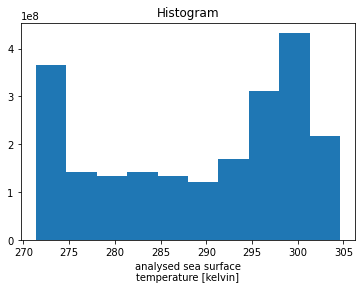

In [12]:
#Histogram
cloud_data['analysed_sst'].plot()


[########################################] | 100% Completed |  1.8s


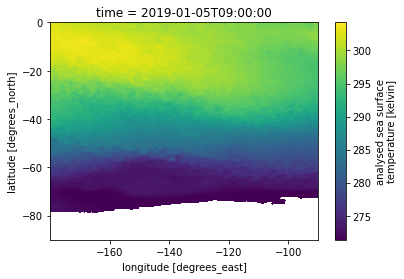

In [13]:
# Choose one time segment, plot the data
cloud_data['analysed_sst'].isel(time=4).plot()


[########################################] | 100% Completed |  0.3s


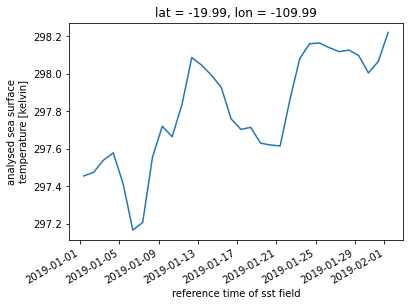

In [14]:
#Plot a single point over time
cloud_data['analysed_sst'].isel(lat=7000, lon=7000).plot()
